In [1]:
import os
import cv2
import numpy as np
import torch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from typing import Optional
from small_gg import SmallGGAutoencoder
from codec import Chunker, custom_load_img
import random

In [3]:
def show(chunk):
    """
    Given a 2-dimensional greyscale rep of an image, show it
    """
    plt.imshow(chunk, cmap="gray", vmin=0.0, vmax=1.0)
    plt.axis("off")
    plt.show()

def show2(chunk1, chunk2):
    """
    Given two 2-dimensional grayscale representations of images, show them side by side.
    """
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(chunk1.squeeze(), cmap="gray", vmin=0.0, vmax=1.0)
    axes[0].axis("off")
    axes[1].imshow(chunk2.squeeze(), cmap="gray", vmin=0.0, vmax=1.0)
    axes[1].axis("off")
    plt.show()

In [4]:
img = custom_load_img("frames/basic/i/frame_0.png")
chunks = [chunk for chunk in Chunker(img).to_chunks()]

In [5]:
def generate_simple_test(chunk, shift):
    """
    Given a chunk (16x16 ndarray) and shift (tuple[int, int]) produce a
    48x48 ndarray with the 16x16 in the center, offset by shift
    """
    result = np.zeros((48, 48), dtype=chunk.dtype)
    result[16 + shift[1] : 16 + shift[1] + 16, 16 + shift[0] : 16 + shift[0] + 16] = chunk
    return result

Visualizing test case...


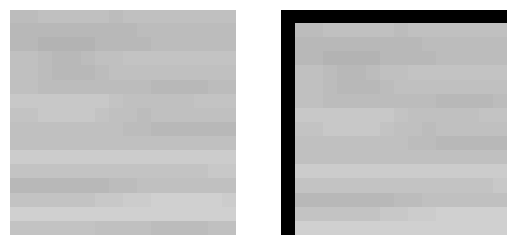


Visualizing actual prelude difference...


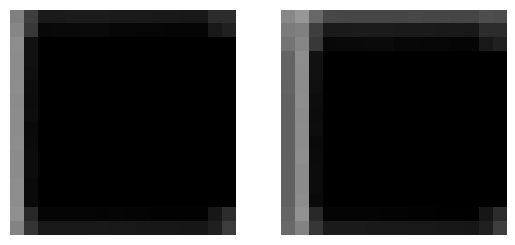

tensor(0.5347, grad_fn=<SelectBackward0>)
Showing naive difference


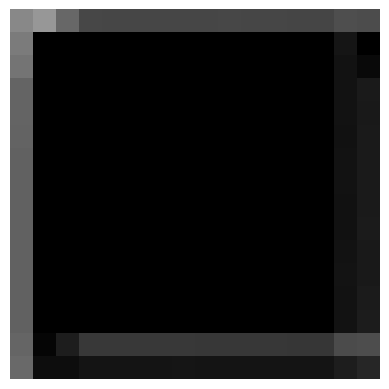

In [6]:
shift = (1, 1)
chunk = random.choice(chunks)
test = generate_simple_test(chunk.detach().numpy().reshape((16, 16)), shift)
post_chunk = test[16 : 32, 16 : 32]
post_chunk = torch.from_numpy(post_chunk).unsqueeze(0)
print("Visualizing test case...")
show2(chunk.detach().numpy().reshape((16, 16)), post_chunk)

model = SmallGGAutoencoder.load_model("autoencoders/gen3_200.pt")
og_prelude, og_bed = model.embed_with_prelude(chunk)
correct_prelude, correct_bed = model.embed_with_prelude(post_chunk)
print("")
print("Visualizing actual prelude difference...")
show2(og_prelude.detach().numpy(), correct_prelude.detach().numpy())

prelude_size = 16
naive_prelude = np.zeros((prelude_size, prelude_size), dtype=np.float32)
relevant = og_prelude.detach().numpy().reshape((prelude_size, prelude_size))
naive_prelude[shift[1] : prelude_size, shift[0] : prelude_size] = relevant[0 : prelude_size - shift[1], 0 : prelude_size - shift[0]]
print(correct_prelude[0,0,0])

print("Showing naive difference")
correct_clean = correct_prelude.detach().numpy().reshape((prelude_size, prelude_size))
show(np.abs(naive_prelude - correct_clean))


In [7]:
img = custom_load_img("frames/basic/i/frame_0.png")
chunks = [chunk for chunk in Chunker(img, custom_size=48).to_chunks()]

In [54]:
def shift_chunk(chunk, shift):
    """
    Shift a chunk
    """
    result = chunk.copy()
    result = np.roll(result, shift[0], axis=0)
    result = np.roll(result, shift[1], axis=1)
    return result

def simulate_diff(chunk, frac_random=0.25):
    """
    Slightly too lazy to actually get the chunks from consecutive frames so
    just going to add in some randomness
    Will replace `frac_random` of the entries with 1/64 * random number in [0, 63]
    NOTE: Does NOT modify chunk returns a new chunk
    """
    num_set = int((chunk.shape[0] * chunk.shape[1]) * frac_random)
    result = chunk.copy()
    for _ in range(num_set):
        row = random.randint(0, chunk.shape[0] - 1)
        col = random.randint(0, chunk.shape[1] - 1)
        mult = sum([random.randint(-1, 1) for _ in range(3)])
        new_val = result[row, col] + 1.0 / 64.0 * mult
        result[row, col] = max(min(new_val, 1.0), 0.0)
    return result


Will be running test on the following chunks


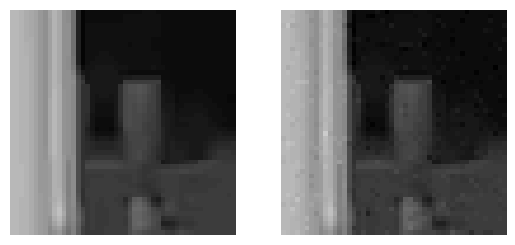

In [55]:
# ix = random.randint(0, len(chunks) - 1)
ix = 92
chunk_tens = chunks[ix]
chunk_np = chunk_tens.detach().numpy().reshape((48, 48))
chunk = chunks[ix].detach().numpy().reshape((48, 48))
shift = (1, 2)
shifted = shift_chunk(chunk, shift)
diff = simulate_diff(chunk)
print("Will be running test on the following chunks")
show2(chunk, diff)

In [18]:
"""
What's left to do?

I need to generate good visuals for showing how to use equivariance to estimate the embedding

I need real data about how inaccurate the embedding is

I need real data about how fast it is compared to naive way

I need to compare it to a somewhat good out-of-the-box CV model
"""

"\nWhat's left to do?\n\nI need to generate good visuals for showing how to use equivariance to estimate the embedding\n\nI need real data about how inaccurate the embedding is\n\nI need real data about how fast it is compared to naive way\n\nI need to compare it to a somewhat good out-of-the-box CV model\n"